CVT Iterations: 100%|██████████| 100/100 [00:00<00:00, 243.46it/s]


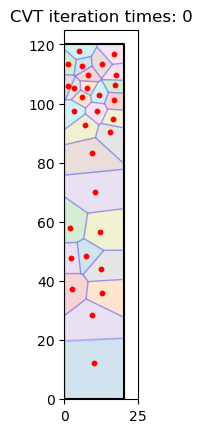

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString, MultiPolygon
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

# 定义几何边界的顶点，注意需要顺次连接
mypolygon_vertices = np.array([[0, 0], [0, 120], [20,120],[20, 0]])
mypolygon = Polygon(mypolygon_vertices)

# 生成在多边形内随机点
def generate_uniform_points_in_mypolygon(vertices, num_points):
    points = []
    while len(points) < num_points:
        r1, r2 = np.random.rand(2)
        if r1 + r2 <= 1:
            new_point = (1 - r1 - r2) * vertices[0] + r1 * vertices[1] + r2 * vertices[2]
            points.append(new_point)
    return np.array(points)

# 构造有限的Voronoi区域（标准版本）
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions to finite regions.
    
    实现逻辑和原理：
    Voronoi 图中的某些区域可能会延伸到无限远，这个函数通过添加虚拟顶点来将这些无限区域转换为有限区域。
    具体步骤如下：
    1. 初始化新的区域和顶点列表。
    2. 计算中心点和默认半径。
    3. 构建所有边的映射。
    4. 处理有限区域，直接添加到新的区域列表中。
    5. 处理无限区域，通过添加虚拟顶点将其转换为有限区域。
    6. 返回新的有限区域和顶点列表。
    
    参数：
    vor: scipy.spatial.Voronoi 对象，表示 Voronoi 图。
    radius: 用于限制无限区域的半径。如果未提供，将使用默认值。
    
    返回：
    new_regions: 新的有限区域列表。
    new_vertices: 新的顶点列表，包括原始顶点和添加的虚拟顶点。
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    # 初始化新的区域和顶点列表
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    # 计算中心点和默认半径
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2
    
    # 构建所有边的映射
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # 处理每个点的区域
    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        
        # 如果区域中的所有顶点都是有限的，直接添加到新的区域列表中
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue
        
        # 处理无限区域
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            # 找到无限延伸的边
            if v2 < 0:
                v = v1
            elif v1 < 0:
                v = v2
            else:
                continue
            
            # 计算虚拟顶点的位置
            v_coords = vor.vertices[v]
            tangent = vor.points[p2] - vor.points[p1]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            direction = np.sign(np.dot(v_coords - center, normal)) * normal
            far_point = vor.vertices[v] + direction * radius
            
            # 添加虚拟顶点到顶点列表中
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)
        
        # 对区域的顶点进行排序
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = [v for _, v in sorted(zip(angles, new_region))]
        
        # 添加新的有限区域到区域列表中
        new_regions.append(new_region)
        
    return new_regions, np.asarray(new_vertices)

# CVT的实现：通过Lloyd迭代，将点移动到其Voronoi区域的质心
def centroidal_voronoi_tessellation(vertices, num_points, num_iterations=100):
    """
    实现逻辑和原理：
    该函数通过Lloyd迭代实现了Centroidal Voronoi Tessellation (CVT)。
    具体步骤如下：
    1. 在给定的多边形内生成初始的随机点。
    2. 迭代若干次，每次迭代中：
       a. 计算当前点集的Voronoi图。
       b. 对于每个Voronoi区域，计算其与多边形的交集。
       c. 计算交集区域的质心，并将点移动到质心位置。
       d. 保存每次迭代后的点集。
    3. 返回所有迭代的点集，以便后续绘制动画或进一步处理。
    
    参数：
    vertices: 多边形的顶点列表，用于定义多边形区域。
    num_points: 初始生成的随机点的数量。
    num_iterations: 迭代次数。
    
    返回：
    frames: 每次迭代后的点集列表。
    """
    points = generate_uniform_points_in_mypolygon(vertices, num_points)
    frames = []
    
    # 创建多边形的多边形
    mypolygon = Polygon(vertices)
    
    for iteration in tqdm(range(num_iterations), desc="CVT Iterations"):
        if len(points) < 2:
            print(f"Iteration {iteration}: 点数不足，无法构建Voronoi图。")
            continue
        
        vor = Voronoi(points)
        new_points = []
        
        # 获取有限的Voronoi区域
        regions, vertices_voronoi = voronoi_finite_polygons_2d(vor)
        
        for point_idx, region in enumerate(regions):
            if len(region) == 0:
                continue
            polygon = [vertices_voronoi[i] for i in region]
            poly = Polygon(polygon)
            if not poly.is_valid:
                poly = poly.buffer(0)
            # 与多边形相交
            intersection = poly.intersection(mypolygon)
            if intersection.is_empty or intersection.area == 0:
                continue
            # 处理MultiPolygon的情况
            if isinstance(intersection, MultiPolygon):
                # 计算所有多边形部分的加权质心
                total_area = 0
                centroid_sum = np.zeros(2)
                for part in intersection:
                    area = part.area
                    centroid = np.array(part.centroid.coords[0])
                    centroid_sum += area * centroid
                    total_area += area
                centroid = centroid_sum / total_area
            else:
                centroid = np.array(intersection.centroid.coords[0])
            # 检查质心是否在交集内
            if not intersection.contains(Point(centroid)):
                centroid = np.array(intersection.representative_point().coords[0])
            new_points.append(centroid)
        
        if len(new_points) > 0:
            points = np.array(new_points)
        else:
            print(f"Iteration {iteration}: 没有新的点，迭代停止。")
            break
            
        # 保存每次迭代的点
        frames.append(points.copy())
        
    return frames
# 绘制Voronoi图和多边形
def plot_voronoi_in_mypolygon(vertices, points, iteration):
    """
    实现逻辑和原理：
    该函数用于绘制给定点集的Voronoi图，并将其限制在指定的多边形区域内。
    具体步骤如下：
    1. 清除当前的绘图。
    2. 检查点的数量是否足够构建Voronoi图。
    3. 计算当前点集的Voronoi图。
    4. 获取有限的Voronoi区域，并与多边形区域相交。
    5. 绘制相交后的Voronoi区域。
    6. 绘制多边形的边界。
    7. 绘制生成的点。
    
    参数：
    vertices: 多边形的顶点列表，用于定义多边形区域。
    points: 当前迭代的点集。
    iteration: 当前迭代次数，用于在标题中显示。
    """
    plt.clf()  # 清除当前的绘图
    if len(points) < 2:
        print(f"Skipping frame {iteration}: Not enough points to construct Voronoi diagram.")
        return
    
    vor = Voronoi(points)  # 计算Voronoi图
    
    # 创建多边形的多边形
    mypolygon = Polygon(vertices)
    
    # 获取有限的Voronoi区域
    regions, vertices_voronoi = voronoi_finite_polygons_2d(vor)
    
    # 绘制Voronoi图
    for region in regions:
        if len(region) == 0:
            continue
        polygon = [vertices_voronoi[i] for i in region]
        poly = Polygon(polygon)
        if not poly.is_valid:
            poly = poly.buffer(0)
        intersection = poly.intersection(mypolygon)
        if intersection.is_empty or intersection.area == 0:
            continue
        if isinstance(intersection, Polygon):
            x, y = intersection.exterior.xy
            plt.fill(x, y, edgecolor='blue', alpha=0.2)
        elif isinstance(intersection, MultiPolygon):
            for part in intersection:
                x, y = part.exterior.xy
                plt.fill(x, y, edgecolor='blue', alpha=0.2)
    
    # 绘制多边形
    x_tri, y_tri = mypolygon.exterior.xy
    plt.plot(x_tri, y_tri, 'k-')
    
    # 绘制生成的点
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10)  # 调整点的大小，s=10 表示较小的点
    plt.title(f"CVT iteration times: {iteration}")
    plt.xlim([0, 25])
    plt.ylim([0, 125])
    plt.gca().set_aspect('equal', adjustable='box')
    
    
# 生成nums个点，迭代num_iterations次
num_points = 30
num_iterations = 100
frames = centroidal_voronoi_tessellation(mypolygon_vertices, num_points, num_iterations=num_iterations)

# 创建动画
fig = plt.figure()
ani = FuncAnimation(fig, lambda i: plot_voronoi_in_mypolygon(mypolygon_vertices, frames[i], i), frames=len(frames), interval=100)

# 保存为GIF
ani.save("voronoi_cvt_test.gif", writer=PillowWriter(fps=10))
